In [2]:
import os, sys, glob, scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

# Load data

# Simulate data

## Learning Model

The learning model used to generate choices is a simple Rescorla-Wagner (Rescorla & Wagner, 1972) model.

$$ Q(action, trial) = Q(action, trial - 1) + \alpha*prediction_{error}$$
$$ prediction_{error} = r(trial-1) - Q(action, trial - 1)$$
$$ 0 <= \alpha <= 1 $$

### Softmax

In [3]:
def softmax(q_values, beta):
    # Inputs:
    #       q_values: value of different actions, often just 2
    #       beta: inverse temperature, also known as exploitation parameter
    # Outputs:
    #       choice_probs: model's predicted probability of actions

    # Numerator represents value of utility of single choice
    numerator = np.exp(np.multiply(q_values, beta))

    # Denominator represents sum of total value of utilities
    denominator = np.sum(np.exp(np.multiply(q_values, beta)))
    
    # Outputs
    choice_probs = numerator / denominator
        
    return choice_probs
softmax(np.zeros(2), beta = .1)

array([0.5, 0.5])

In [4]:
def task_parameters(volatility = 'low'): 
    
    # Generate dataframe to store simulated results
    sim_exp = pd.DataFrame(columns = ['volatility', 'block', 'block_trial', 'exp_trial', 
                                       'prob_reward_left', 'prob_reward_right', 'reward_left', 'reward_right'])
    
    # Trial sequence
    block_seq = [[17, 15, 19, 18, 15, 17, 19, 15], # high volatility
                [35, 30, 35, 35]] # low volatility
    reward_probs_left = [.7, .3] 
    reward_probs_right = [.3, .7] 

    if volatility == 'low':
        task_blocks = block_seq[1]
        block_prob_reward_left = np.array(reward_probs_left*(np.int(len(task_blocks)/2)))
        block_prob_reward_right = np.array(reward_probs_right*(np.int(len(task_blocks)/2)))
    else: 
        task_blocks = block_seq[0]
        block_prob_reward_left = np.array(reward_probs_left*(np.int(len(task_blocks)/2)))
        block_prob_reward_right = np.array(reward_probs_right*(np.int(len(task_blocks)/2)))

    # generate trials
    trial = 0
    for block in range(len(task_blocks)): 
        block_trial = 0
        # Loop through trials of the block
        for block_trial in range(task_blocks[block]):
            trial += 1
            block_trial += 1
            
            # Generate reward for both choices
            prob_reward_left = block_prob_reward_left[block] # pulls correct probability for left
            prob_reward_right = block_prob_reward_right[block] # pulls correct probability for right
            
            # Left choice
            if np.random.rand() <= prob_reward_left:
                reward_left = 1
            else: 
                reward_left = 0
                
            # Right choice
            if np.random.rand() <= prob_reward_right:
                reward_right = 1
            else: 
                reward_right = 0
                
            # Store results
            trial_data = pd.DataFrame([[volatility, block+1, block_trial, trial, 
                                        prob_reward_left, prob_reward_right, reward_left, reward_right]], 
                                     columns = ['volatility', 'block', 'block_trial', 'exp_trial', 
                                       'prob_reward_left', 'prob_reward_right', 'reward_left', 'reward_right'])
            sim_exp = sim_exp.append(trial_data).reset_index(drop=True)
            
    return sim_exp
sim_exp = task_parameters(volatility = 'low')
sim_exp.head(5)

,volatility,block,block_trial,exp_trial,prob_reward_left,prob_reward_right,reward_left,reward_right
0,low,1,1,1,0.7,0.3,0,1
1,low,1,2,2,0.7,0.3,0,0
2,low,1,3,3,0.7,0.3,1,0
3,low,1,4,4,0.7,0.3,1,1
4,low,1,5,5,0.7,0.3,1,0


### Reinforcement Learning

In [5]:
def rl_simulate(params, sim_exp): 
    data = sim_exp.copy()
    # Initialize parameters
    # two alphas? (positive vs negative pes), stickiness? (likelihood of just repeating past action)
    # two-step modeling
    alpha = params[0] # learning param
    beta = params[1] # exploitation param
    q_values = [.5, .5] # q-values for left and right choices start at .5
    
    # Loop over rows in data
    for index, row in data.iterrows(): # loop over rows, slow but easy to understand and index
        
        # Compute probability of chosing left or right
        choice_probs = softmax(q_values, beta) 
        
        # Make choice weighted by probabilities
        # probabilities given by left, right
        if np.random.rand() <= choice_probs[0]:
            choice = 'left'
            choice_num = 0
        else:
            choice = 'right'
            choice_num = 1

                    
        # Store (keep above update)      
        data.at[index, 'choice'] = choice # useful way to append single values
        data.at[index, 'choice_num'] = choice_num
        data.at[index, 'prob_left'] = choice_probs[0]
        data.at[index, 'prob_right'] = choice_probs[1]
        data.at[index, 'q_left'] = q_values[0]
        data.at[index, 'q_right'] = q_values[1]
        
        # Update q_values (to be used on next trial)
        # All the magic happens here
        if choice == 'left':
            pe = row['reward_left'] - q_values[choice_num] # compute pe = reward - q_value['choice']
            q_values[choice_num] = q_values[choice_num] + alpha*pe # update value
        else:
            pe = row['reward_right'] - q_values[choice_num] # compute pe
            q_values[choice_num] = q_values[choice_num] + alpha*pe # update value
                
    # Add final information
    data['alpha'] = alpha
    data['beta'] = beta
    
    return data

# Fit simulated data

Now using the simulated data with alpah and beta 0.5, I need to fit the simulated behavior.

In [6]:
def rl_simulate_fit(params, data): 
    
    # Initialize parameters
    # two alphas? (positive vs negative pes), stickiness? (likelihood of just repeating past action)
    # two-step modeling
    alpha = params[0] # learning param
    beta = params[1] # exploitation param
    q_values = [.5, .5] # q-values for left and right choices start at .5
    log_likelihood = 0.
    
    # Loop over rows in data
    for index, row in data.iterrows(): # loop over rows, slow but easy to understand and index
        
        # Compute probability of chosing left or right
        choice_probs = softmax(q_values, beta)
        
        choice = np.int(row['choice_num'])
        
        rewards = [np.int(row['reward_left']), np.int(row['reward_right'])]
        reward = rewards[choice]
        
        # Update likelihood
        log_likelihood += np.log(choice_probs[choice]) # index based on choice 

        pe = reward - q_values[choice] # compute pe = reward - q_value['choice']
        q_values[choice] = q_values[choice] + alpha*pe # update value
                 
    return -log_likelihood

In [16]:
params_true = [0.3, 1]
n_iter = 20
sim_exp = task_parameters(volatility = 'low')
sim_data = rl_simulate(params_true, sim_exp)
    
objective_function = lambda params: rl_simulate_fit(params, sim_data)
        
fit_results = pd.DataFrame()
for j in tqdm.tqdm(range(n_iter)):
    x0 = np.random.rand(2)
    out = scipy.optimize.fmin(objective_function, x0, full_output=True)
    best_params, best_NLL = out[:2]
    fit_results = fit_results.append(pd.DataFrame([[j, best_params, best_NLL]],
                                             columns = ['iteration','best_params','best_NLL']))

        
# After each iteration, extract the parameters with the max NLL
index = np.where(fit_results == np.max(fit_results[['best_NLL']]))[0][0]
alpha = fit_results.iloc[index, 1][0]
beta = fit_results.iloc[index, 1][1]



  5%|██▏                                        | 1/20 [00:03<01:11,  3.79s/it]

Optimization terminated successfully.
         Current function value: 87.359494
         Iterations: 58
         Function evaluations: 110


 10%|████▎                                      | 2/20 [00:06<01:02,  3.46s/it]

Optimization terminated successfully.
         Current function value: 87.359494
         Iterations: 46
         Function evaluations: 88


 15%|██████▍                                    | 3/20 [00:09<00:55,  3.24s/it]

Optimization terminated successfully.
         Current function value: 87.359494
         Iterations: 55
         Function evaluations: 106


 20%|████████▌                                  | 4/20 [00:12<00:51,  3.22s/it]

Optimization terminated successfully.
         Current function value: 87.359494
         Iterations: 49
         Function evaluations: 93


c:\users\lotte\anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log
c:\users\lotte\anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
c:\users\lotte\anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':
c:\users\lotte\anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
 25%|██████████▊                                | 5/20 [00:17<00:56,  3.75s/it]

Optimization terminated successfully.
         Current function value: 87.359494
         Iterations: 56
         Function evaluations: 108


 30%|████████████▉                              | 6/20 [00:20<00:50,  3.64s/it]

Optimization terminated successfully.
         Current function value: 87.359494
         Iterations: 52
         Function evaluations: 100


 35%|███████████████                            | 7/20 [00:24<00:46,  3.54s/it]

Optimization terminated successfully.
         Current function value: 87.359494
         Iterations: 56
         Function evaluations: 109


 40%|█████████████████▏                         | 8/20 [00:27<00:40,  3.38s/it]

Optimization terminated successfully.
         Current function value: 87.359494
         Iterations: 57
         Function evaluations: 107


 45%|███████████████████▎                       | 9/20 [00:31<00:39,  3.61s/it]

Optimization terminated successfully.
         Current function value: 87.359494
         Iterations: 67
         Function evaluations: 124


 50%|█████████████████████                     | 10/20 [00:34<00:36,  3.62s/it]

Optimization terminated successfully.
         Current function value: 87.359494
         Iterations: 53
         Function evaluations: 100


 55%|███████████████████████                   | 11/20 [00:37<00:30,  3.37s/it]

Optimization terminated successfully.
         Current function value: 87.359494
         Iterations: 51
         Function evaluations: 98


 60%|█████████████████████████▏                | 12/20 [00:41<00:27,  3.43s/it]

Optimization terminated successfully.
         Current function value: 87.359494
         Iterations: 55
         Function evaluations: 103


 65%|███████████████████████████▎              | 13/20 [00:44<00:23,  3.31s/it]

Optimization terminated successfully.
         Current function value: 87.359494
         Iterations: 60
         Function evaluations: 114


 70%|█████████████████████████████▍            | 14/20 [00:47<00:19,  3.26s/it]

Optimization terminated successfully.
         Current function value: 87.359494
         Iterations: 64
         Function evaluations: 122


 75%|███████████████████████████████▌          | 15/20 [00:50<00:16,  3.25s/it]

Optimization terminated successfully.
         Current function value: 87.359494
         Iterations: 65
         Function evaluations: 122


 80%|█████████████████████████████████▌        | 16/20 [00:54<00:13,  3.30s/it]

Optimization terminated successfully.
         Current function value: 87.359494
         Iterations: 58
         Function evaluations: 108


 85%|███████████████████████████████████▋      | 17/20 [00:56<00:09,  3.13s/it]

Optimization terminated successfully.
         Current function value: 87.359494
         Iterations: 56
         Function evaluations: 107


 90%|█████████████████████████████████████▊    | 18/20 [00:59<00:05,  2.91s/it]

Optimization terminated successfully.
         Current function value: 87.359494
         Iterations: 52
         Function evaluations: 99


 95%|███████████████████████████████████████▉  | 19/20 [01:01<00:02,  2.86s/it]

Optimization terminated successfully.
         Current function value: 87.359494
         Iterations: 57
         Function evaluations: 112


100%|██████████████████████████████████████████| 20/20 [01:04<00:00,  3.22s/it]

Optimization terminated successfully.
         Current function value: 87.359494
         Iterations: 53
         Function evaluations: 101


In [14]:
fit_results

,iteration,best_params,best_NLL
0,9,"[0.23081788319962165, 1.0046693797026855]",90.786951
0,9,"[0.23081301533601445, 1.0046936741572323]",90.786951
0,9,"[0.23083361326907925, 1.0046501342814351]",90.786951
0,9,"[0.23082752323851724, 1.0046553452453146]",90.786951
0,9,"[0.23082767086659386, 1.004672734291151]",90.786951
0,9,"[0.2308567541698086, 1.004658196259077]",90.786951
0,9,"[0.23082308416571404, 1.0046881330502304]",90.786951
0,9,"[0.23082105094777733, 1.0046909619544406]",90.786951
0,9,"[0.2308453134831542, 1.004628502780145]",90.786951
0,9,"[0.2308402351746023, 1.0046424066514321]",90.786951


KeyError: 'best_params'

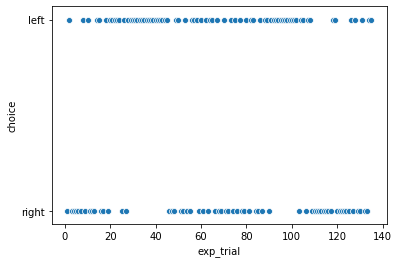

In [12]:
sns.scatterplot(x = sim_data['exp_trial'], y = sim_data['choice'])